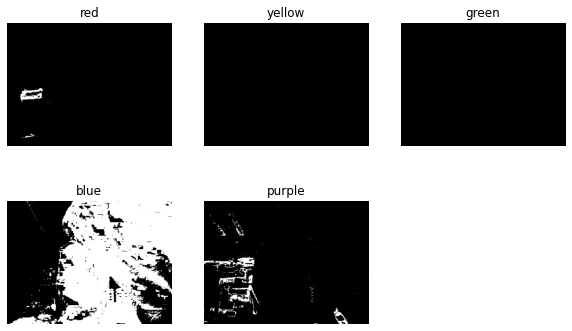

木ドロップ0
水ドロップ7
光ドロップ0
闇ドロップ14
回復ドロップ0
火ドロップ9


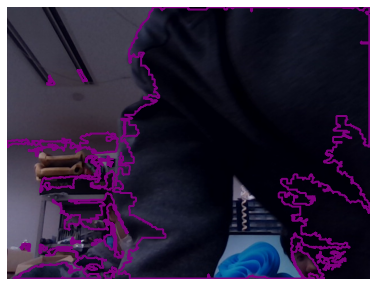

合計コンボ数9


In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import tkinter as tk
from PIL import Image, ImageTk



#定義
hidoro = 0 #火ドロップの数
kidoro = 0 #木ドロップの数
mizudoro = 0 #水ドロップの数
yamidoro = 0 #闇ドロップの数
hikadoro = 0 #光ドロップの数
RESIZE_SCALE=0.5 #リサイズする倍率

#GUI作成
# ウィンドウの作成
root = tk.Tk()
root.title("パズドラコンボ")
root.geometry("480x720")

# ファイルを参照
#background = tk.PhotoImage(file="king_3.png")
image_bgr = cv2.imread("king_3.png")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # imreadはBGRなのでRGBに変換
image_pil = Image.fromarray(image_rgb) # RGBからPILフォーマットへ変換
image_tk  = ImageTk.PhotoImage(image_pil) # ImageTkフォーマットへ変換

canvas = tk.Canvas(root, width=image_bgr.shape[1], height=image_bgr.shape[0]) # Canvas作成
canvas.pack()
canvas.create_image(0, 0, image=image_tk, anchor='nw') # ImageTk 画像配置

# Labelの作成
#bg = tk.Label(root, image=background)
#bg.pack(fill="x")

# pt0-> pt1およびpt0-> pt2からの
# ベクトル間の角度の余弦(コサイン)を算出
def angle(pt1, pt2, pt0) -> float:
    dx1 = float(pt1[0,0] - pt0[0,0])
    dy1 = float(pt1[0,1] - pt0[0,1])
    dx2 = float(pt2[0,0] - pt0[0,0])
    dy2 = float(pt2[0,1] - pt0[0,1])
    v = math.sqrt((dx1*dx1 + dy1*dy1)*(dx2*dx2 + dy2*dy2) )
    return (dx1*dx2 + dy1*dy2)/ v

# 画像上の四角形を検出
def findSquares(bin_image, img, cond_area = 1000):
    # 輪郭取得
    contours, _= cv2.findContours(bin_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    kaihuku = 0
    for i, cnt in enumerate(contours):
        # 輪郭の周囲に比例する精度で輪郭を近似する
        arclen = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, arclen*0.02, True)
       
        #四角形の輪郭は、近似後に4つの頂点があります。
        #比較的広い領域が凸状になります。

        # 凸性の確認 
        area = abs(cv2.contourArea(approx))
        if approx.shape[0] == 4 and area > cond_area and cv2.isContourConvex(approx) :
            maxCosine = 0

            for j in range(2, 5):
                # 辺間の角度の最大コサインを算出
                cosine = abs(angle(approx[j%4], approx[j-2], approx[j-1]))
                maxCosine = max(maxCosine, cosine)
                kaihuku += 1

            # すべての角度の余弦定理が小さい場合
            #（すべての角度は約90度です）次に、quandrangeを書き込みます
            # 結果のシーケンスへの頂点
            if maxCosine < 0.3 :
                # 四角判定!!
                rcnt = approx.reshape(-1,2)
                cv2.polylines(img, [rcnt], True, (0,0,255), thickness=2, lineType=cv2.LINE_8)
    return img,kaihuku


cap = cv2.VideoCapture(0)
ret, img = cap.read()

# 色基準で2値化する。
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # HSV 色空間に変換

# 赤色のHSVの値域1
hsv_min = np.array([0,64,0])
hsv_max = np.array([10,255,255])
mask1 = cv2.inRange(hsv, hsv_min, hsv_max)

# 赤色のHSVの値域2
hsv_min = np.array([175,64,0])
hsv_max = np.array([179,255,255])
mask2 = cv2.inRange(hsv, hsv_min, hsv_max)

# マスク領域（255：赤色、0：赤色以外）    
red= mask1 + mask2
yellow = cv2.inRange(hsv, np.array([25, 80, 0]), np.array([40, 255, 255]))
green = cv2.inRange(hsv, np.array([35, 50, 0]), np.array([75, 255, 255]))
blue = cv2.inRange(hsv, np.array([90, 64, 0]), np.array([120, 255, 255]))
purple = cv2.inRange(hsv, np.array([130, 64, 0]), np.array([155, 255, 255]))


bin_imgs = {'red': red, 'yellow': yellow, 'green': green,
            'blue': blue, 'purple': purple}

# 2値化結果を可視化する。
####################################################
fig, axes_list = plt.subplots(2, 3, figsize=(10, 6))
axes_list[1, 2].remove()
for ax, (label, bin_img) in zip(axes_list.ravel(), bin_imgs.items()):
    ax.axis('off')
    ax.set_title(label)
    ax.imshow(bin_img, cmap=plt.cm.gray)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
ax.axis('off')
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 輪郭検出し、数を求める。
##############################################
    
#木ドロップ検出    
contours, _ = cv2.findContours(green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 輪郭を構成する頂点数で誤検出を除く。
contours = list(filter(lambda cnt: len(cnt) > 30, contours))
count = len(contours)

kidoro= count
print(f'木ドロップ{kidoro}')
        
# 描画する。
for cnt in contours:
    cnt = np.squeeze(cnt, axis=1)  # (N, 1, 2) -> (N, 2)
    ax.add_patch(Polygon(cnt, fill=None, lw=2., color=label))  # 輪郭の点同士を結ぶ線を描画する。

    
#水ドロップ検出    
contours, _ = cv2.findContours(blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 輪郭を構成する頂点数で誤検出を除く。
contours = list(filter(lambda cnt: len(cnt) > 30, contours))
count = len(contours)

mizudoro = count
print(f'水ドロップ{mizudoro}')
        
# 描画する。
for cnt in contours:
    cnt = np.squeeze(cnt, axis=1)  # (N, 1, 2) -> (N, 2)
    ax.add_patch(Polygon(cnt, fill=None, lw=2., color=label))
    
    
#光ドロップ検出    
contours, _ = cv2.findContours(yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 輪郭を構成する頂点数で誤検出を除く。
contours = list(filter(lambda cnt: len(cnt) > 30, contours))
count = len(contours)

hikadoro = count
print(f'光ドロップ{hikadoro}')
        
# 描画する。
for cnt in contours:
    cnt = np.squeeze(cnt, axis=1)  # (N, 1, 2) -> (N, 2)
    ax.add_patch(Polygon(cnt, fill=None, lw=2., color=label))
    

#闇ドロップ検出
contours, _ = cv2.findContours(purple, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 輪郭を構成する頂点数で誤検出を除く。
contours = list(filter(lambda cnt: len(cnt) > 30, contours))
count = len(contours)

yamidoro = count
print(f'闇ドロップ{yamidoro}')
        
# 描画する。
for cnt in contours:
    cnt = np.squeeze(cnt, axis=1)  # (N, 1, 2) -> (N, 2)
    ax.add_patch(Polygon(cnt, fill=None, lw=2., color=label))

#グレースケール
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#四角検出
_,bw = cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
rimg, kaihukuda = findSquares(bw, img)

kaihukudesu = int(kaihukuda/3)

print(f'回復ドロップ{int(kaihukudesu)}')

hidoro = int(30 - (kidoro + mizudoro + hikadoro + yamidoro + kaihukudesu))

print(f'火ドロップ{hidoro}')

plt.show()



#コンボ計算
hikon = int(hidoro /3)
kikon = int(kidoro /3)
mizukon = int(mizudoro /3)
hikakon = int(hikadoro /3)
yamikon = int(yamidoro /3)
kaikon = int(kaihukudesu /3)
goukon = hikon + kikon + mizukon + hikakon + yamikon + kaikon

print(f'合計コンボ数{hikon + kikon + mizukon + hikakon + yamikon + kaikon}')


# ラベル
label = tk.Label(text=f'火ドロップ　{hidoro}個　コンボ数{hikon}', foreground='red',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=10, y=10)


label = tk.Label(text=f'木ドロップ　{kidoro}個　コンボ数{kikon}', foreground='green',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=10, y=60)


label = tk.Label(text=f'水ドロップ　{mizudoro}個　コンボ数{mizukon}', foreground='blue',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=10, y=110)


label = tk.Label(text=f'光ドロップ　{hikadoro}個　コンボ数{hikakon}', foreground='yellow',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=10, y=160)


label = tk.Label(text=f'闇ドロップ　{yamidoro}個　コンボ数{yamikon}', foreground='black',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=10, y=210)


label = tk.Label(text=f'回復ドロップ　{kaihukudesu}個　コンボ数{kaikon}', foreground='Deeppink',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=10, y=260)


label = tk.Label(text=f'最大コンボ数　{goukon}', foreground='gold',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=10, y=310)


label = tk.Label(text='盤面', foreground='skyblue',background='purple',font=("MSゴシック", "20", "bold"))
label.place(x=130, y=360)

#盤面の画像を配置
img_height = img.shape[0]
img_width = img.shape[1]
img_resize = cv2.resize(img,(int(img_width*RESIZE_SCALE),int(img_height*RESIZE_SCALE)))
image_rgb2 = cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB) # imreadはBGRなのでRGBに変換
image_pil2 = Image.fromarray(image_rgb2) # RGBからPILフォーマットへ変換
image_tk2  = ImageTk.PhotoImage(image_pil2) # ImageTkフォーマットへ変換

label = tk.Label(root, image=image_tk2)
label.place(x=10,y=400)







root.mainloop()
cv2.waitKey(0)   
cap.release() 
cv2.destroyAllWindows()


